PART 1


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

In [6]:
IMAGE_SIZE = 32
transform = transforms.Compose(
    [transforms.Resize(IMAGE_SIZE),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:02, 83037334.69it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

In [8]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.Image as Image

     |████████████████████████████████| 5.6MB 3.1MB/s 
ERROR: torchvision 0.4.2 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [0]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
%matplotlib inline
sns.set(style='darkgrid')

def show(img, renorm=False, nrow=8):
  img_grid = torchvision.utils.make_grid(img, nrow=nrow).numpy()
  plt.figure(figsize=(8,8))
  plt.imshow(np.transpose((img_grid+1)/2, (1,2,0)))
  plt.axis('off')
  plt.show()


In [0]:
reduce_dataset = True
if reduce_dataset:
    used_categories = (2, 4, 6, 8) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data
    trainset.targets = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.targets = new_test_labels


In [11]:
batch_size=128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=1)
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

used classes: ['bird', 'deer', 'frog', 'ship']


In [12]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(trainset.targets)))


print("\n# Test data")
print("Number of points:", len(testset))
x, y = next(iter(testloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(testset.targets)))

# Training data
Number of points: 20000
Batch dimension [B x C x H x W]: torch.Size([128, 3, 32, 32])
Number of distinct labels: 4

# Test data
Number of points: 4000
Batch dimension [B x C x H x W]: torch.Size([128, 3, 32, 32])
Number of distinct labels: 4


 ship  ship  deer  bird  deer  frog  bird  deer  deer  ship  bird  frog  deer  deer  bird  deer  frog  deer  ship  deer  ship  deer  deer  ship  ship  deer  deer  bird  deer  deer  deer  bird  bird  frog  frog  deer  frog  bird  frog  deer  deer  deer  frog  ship  bird  frog  deer  ship  deer  frog  frog  ship  ship  deer  frog  bird  ship  deer  ship  ship  bird  frog  frog  frog  bird  deer  frog  bird  bird  bird  deer  frog  deer  bird  deer  frog  frog  frog  frog  deer  frog  deer  deer  ship  bird  ship  bird  ship  frog  ship  ship  deer  ship  bird  ship  deer  deer  frog  frog  ship  bird  deer  frog  bird  deer  ship  bird  bird  ship  bird  frog  frog  deer  bird  frog  deer  ship  bird  frog  ship  bird  bird  frog  frog  deer  bird  bird  frog


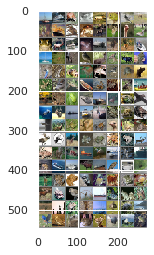

In [19]:
# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

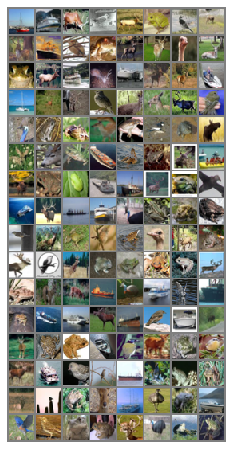

In [20]:
show(images)

In [21]:
images.shape

torch.Size([128, 3, 32, 32])

In [0]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [23]:
device

device(type='cuda', index=0)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Upsampleconv2d(nn.Module):
  def __init__(self,  in_filters=128, num_filters=128, kernel=3, padding=1):
    super(Upsampleconv2d, self).__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(in_filters, num_filters, kernel_size=kernel, padding=padding)
    )

    self.upsample = nn.UpsamplingNearest2d(scale_factor = 2)

  def forward(self, x):
      x = self.upsample(x)
      return self.layers(x)

In [0]:
class Downsampleconv2d(nn.Module):
  def __init__(self, in_filters=128, num_filters=128, kernel=3, padding=1):
    super(Downsampleconv2d, self).__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(in_filters, num_filters, kernel_size=kernel, padding=padding)
    )

    self.downample = nn.AvgPool2d(2)

  def forward(self, x):
      x = self.downample(x)
      return self.layers(x)

In [0]:
class ResidualBlockDown(nn.Module):
  def __init__(self, num_filters=16):
    super(ResidualBlockDown, self).__init__()

    self.num_filters = num_filters

    self.residual = nn.Sequential(
      nn.BatchNorm2d(num_filters),
      nn.ReLU(),
      nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
      nn.BatchNorm2d(num_filters),
      nn.ReLU(),
      Downsampleconv2d(num_filters)
    )

    self.shortcut = Downsampleconv2d(num_filters,num_filters,1,0)


  def forward(self, x):
    return self.residual(x)+ self.shortcut(x)


class ResidualStackDown(nn.Module):
  def __init__(self, num_blocks=3, num_filters=16):
    super(ResidualStackDown, self).__init__()

    self.layers = nn.Sequential(*[ResidualBlockDown(num_filters) for _ in range(num_blocks)])

  def forward(self, x):
    return F.relu(self.layers(x))

In [0]:
class ResidualBlock(nn.Module):
  def __init__(self, num_filters=16):
    super(ResidualBlock, self).__init__()

    self.num_filters = num_filters

    self.residual = nn.Sequential(
      nn.ReLU(),
      nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
      )


  def forward(self, x):
    return self.residual(x)+ x


class ResidualStack(nn.Module):
  def __init__(self, num_blocks=2, num_filters=16):
    super(ResidualStack, self).__init__()

    self.layers = nn.Sequential(*[ResidualBlock(num_filters) for _ in range(num_blocks)])

  def forward(self, x):
    return F.relu(self.layers(x))

In [0]:
class ResidualBlockUp(nn.Module):
  def __init__(self, num_filters=16):
    super(ResidualBlockUp, self).__init__()

    self.num_filters = num_filters

    self.residual = nn.Sequential(
      nn.BatchNorm2d(num_filters),
      nn.ReLU(),
      nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
      nn.BatchNorm2d(num_filters),
      nn.ReLU(),
      Upsampleconv2d(num_filters,num_filters)
    )

    self.shortcut = Upsampleconv2d(num_filters,num_filters,1,0)


  def forward(self, x):
    return self.residual(x)+ self.shortcut(x)


class ResidualStackUp(nn.Module):
  def __init__(self, num_blocks=3, num_filters=16):
    super(ResidualStackUp, self).__init__()

    self.layers = nn.Sequential(*[ResidualBlockUp(num_filters) for _ in range(num_blocks)])

  def forward(self, x):
    return F.relu(self.layers(x))

In [0]:
class Generator(nn.Module):
    def __init__(self, n_filters=256, blocks=3):
        super(Generator, self).__init__()

        self.n_filters = n_filters
        self.blocks = blocks
        self.sample = nn.Linear(128,4 * 4*self.n_filters)
        self.resblock = ResidualStackUp(self.blocks, self.n_filters)
        self.BN = nn.BatchNorm2d(self.n_filters)
        self.conv = nn.Conv2d(self.n_filters, 3, kernel_size=3, padding=1)

    def forward(self, z):
        z = self.sample(z)
        z = z.reshape(-1,self.n_filters,4,4)
        out = self.resblock(z)
        out = self.BN(out)
        out = F.relu(out)
        out = self.conv(out)
        out = torch.tanh(out)
        return out

In [0]:
gen = Generator().to(device)

In [0]:
#z  = torch.randn(n_samples, 128).to(device)
z = torch.FloatTensor(4, 128).to(device)
a = gen.forward(z.normal_(0,1))


In [33]:
a.shape

torch.Size([4, 3, 32, 32])

In [0]:
a=a.detach().cpu()

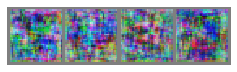

In [42]:
show(a)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, n_filters=128, blocks=2):
        super(Discriminator, self).__init__()

        self.n_filters = n_filters
        self.blocks = blocks
        self.dense = nn.Linear(self.n_filters,1)
        self.resblockdown = ResidualStackDown(self.blocks, self.n_filters)
        self.resblock = ResidualStack(self.blocks, self.n_filters)
        self.conv = nn.Conv2d(3,self.n_filters, kernel_size=1, padding=0)

    def forward(self, x):
        x = self.conv(x)
        x = self.resblockdown(x)
        x = self.resblock(x)
        x = F.relu(x)
        x = torch.sum(x.view(x.size(0), x.size(1), -1), dim=2)
        out = self.dense(x)
        return out #torch.sigmoid(out)

In [0]:
disc = Discriminator(n_filters=128).to(device)

In [38]:
disc(images.to(device)).shape

torch.Size([128, 1])

# Training


In [39]:
device

device(type='cuda', index=0)

In [0]:
discriminator = Discriminator(n_filters=128).to(device)
generator = Generator().to(device)

In [0]:
n_iters = 100000
num_epochs = n_iters / (len(trainloader))
num_epochs = int(num_epochs)

In [44]:
loss = nn.BCELoss()
print("Using device:", device)
from torch.optim.lr_scheduler import LambdaLR

lr = 2e-4
generator_optim = torch.optim.AdamW(generator.parameters(), lr, betas=(0.0, 0.9),weight_decay=0)
discriminator_optim = torch.optim.AdamW(discriminator.parameters(), lr, betas=(0.0, 0.9),weight_decay=0, amsgrad=True)

import numpy as np

decay = lambda global_step : np.linspace(1,0,n_iters+1)[global_step]
scheduler_gen = LambdaLR(generator_optim, decay)
scheduler_disc = LambdaLR(discriminator_optim, decay)


Using device: cuda:0


In [0]:
def calc_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""

    # Random weight term for interpolation between real and fake samples
    alpha = torch.Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    alpha = alpha.to(device)

    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(torch.Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False).to(device)

    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

In [0]:
import torch.autograd as autograd
LAMBDA = 10 # recommended value from the original paper

def calc_gradient_penalty(netD, real_data, fake_data):
    
    alpha = torch.rand(real_data.size(0), 1)
    alpha = alpha.expand(real_data.size(0), int(real_data.nelement()/real_data.size(0))).contiguous().view(real_data.size(0), 3, 32, 32)
    alpha = alpha.to(device)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.to(device)
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
                              
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA

    return gradient_penalty

In [0]:
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # 1.1 Sample noise and generate fake data
    prediction = discriminator(fake_data)

    # 1.2 Calculate error and backpropagate
    G_loss = -torch.mean(prediction)
    G_loss.backward()

    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return G_loss

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    
    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    
    # gradients penalty (Lipschitz condition) (WGAN-GP)
    penalty = calc_gradient_penalty(discriminator,real_data, fake_data)
    loss = prediction_fake.mean() - prediction_real.mean() + penalty
    loss.backward()

    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return loss

In [49]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from torch.autograd import Variable
import os

hw4 = 'hw4_3.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/{hw4}"
global_step = 0
n_critic = 5
epochz=0
discriminator_loss, generator_loss = [], []
incept_mean_list, incept_std_list = [], []

In [51]:

try:
    checkpoint = torch.load(path)
    discriminator.load_state_dict(checkpoint['disc'])
    generator.load_state_dict(checkpoint['gen'])
    discriminator_optim.load_state_dict(checkpoint['disc_optim'])
    generator_optim.load_state_dict(checkpoint['gen_optim'])
    epochz = checkpoint['epoch']
    discriminator_loss = checkpoint['disc_loss']
    generator_loss = checkpoint['gen_loss']
    global_step = checkpoint['global_step']
    incept_mean_list = checkpoint['incept_mean_list']
    incept_std_list = checkpoint['incept_std_list']
except:
    discriminator_loss, generator_loss = [], []
    epochz=0
print(epochz)


500


In [74]:
import os.path
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf
import glob
import scipy.misc
import math
import sys

MODEL_DIR = '/tmp/imagenet'
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
softmax = None

# Call this function with list of images. Each of elements should be a 
# numpy array with values ranging from 0 to 255.
def get_inception_score(images, splits=10):
  assert(type(images) == list)
  assert(type(images[0]) == np.ndarray)
  assert(len(images[0].shape) == 3)
  assert(np.max(images[0]) > 10)
  assert(np.min(images[0]) >= 0.0)
  inps = []
  for img in images:
    img = img.astype(np.float32)
    inps.append(np.expand_dims(img, 0))
  bs = 100
  with tf.Session() as sess:
    preds = []
    n_batches = int(math.ceil(float(len(inps)) / float(bs)))
    for i in range(n_batches):
        # sys.stdout.write(".")
        # sys.stdout.flush()
        inp = inps[(i * bs):min((i + 1) * bs, len(inps))]
        inp = np.concatenate(inp, 0)
        pred = sess.run(softmax, {'ExpandDims:0': inp})
        preds.append(pred)
    preds = np.concatenate(preds, 0)
    scores = []
    for i in range(splits):
      part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
      kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
      kl = np.mean(np.sum(kl, 1))
      scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

# This function is called automatically.
def _init_inception():
  global softmax
  if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(MODEL_DIR, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(MODEL_DIR)
  with tf.gfile.FastGFile(os.path.join(
      MODEL_DIR, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')
  # Works with an arbitrary minibatch size.
  with tf.Session() as sess:
    pool3 = sess.graph.get_tensor_by_name('pool_3:0')
    ops = pool3.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            shape = [s.value for s in shape]
            new_shape = []
            for j, s in enumerate(shape):
                if s == 1 and j == 0:
                    new_shape.append(None)
                else:
                    new_shape.append(s)
            o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    w = sess.graph.get_operation_by_name("softmax/logits/MatMul").inputs[1]
    logits = tf.matmul(tf.squeeze(pool3,[1,2]), w)
    softmax = tf.nn.softmax(logits)

if softmax is None:
  _init_inception()

>> Downloading inception-2015-12-05.tgz 100.0%
Succesfully downloaded inception-2015-12-05.tgz 88931400 bytes.
Instructions for updating:
Use tf.gfile.GFile.


In [0]:
# For calculating inception score
def get_inception_Score(G, ):
    all_samples = []
    for i in range(10):
        samples_100 = torch.FloatTensor(100, 128).to(device)
        with torch.no_grad():
            all_samples.append(G.forward(samples_100.normal_(0,1)).cpu().data.numpy())

    all_samples = np.concatenate(all_samples, axis=0)
    all_samples = np.multiply(np.add(np.multiply(all_samples, 0.5), 0.5), 255).astype('int32')
    all_samples = all_samples.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
    return get_inception_score(list(all_samples))

schedular lr [0.00019968600000000003]
Epoch 1 of 636,  Discriminator loss -8.844543054604985 and Generator loss 19.0878476658836


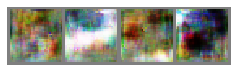

schedular lr [0.00019811600000000003]
Epoch 6 of 636,  Discriminator loss -1.164422621487812 and Generator loss 8.31504156976007


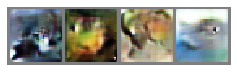

schedular lr [0.000196546]
Epoch 11 of 636,  Discriminator loss -0.510943075416574 and Generator loss 8.812204591929913


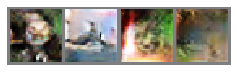

schedular lr [0.000194976]
Epoch 16 of 636,  Discriminator loss -0.4212098925546476 and Generator loss 8.884382620453835


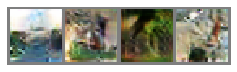

schedular lr [0.00019340600000000002]
Epoch 21 of 636,  Discriminator loss -0.3179040012086273 and Generator loss 9.399137308821082


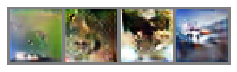

schedular lr [0.00019183600000000002]
Epoch 26 of 636,  Discriminator loss -0.30104665529386254 and Generator loss 10.789493918418884


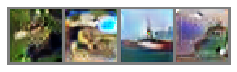

schedular lr [0.000190266]
Epoch 31 of 636,  Discriminator loss -0.3356931401523435 and Generator loss 9.02477978169918


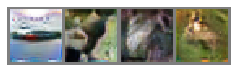

schedular lr [0.000188696]
Epoch 36 of 636,  Discriminator loss -0.30437516041432217 and Generator loss 8.175198331475258


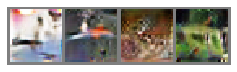

schedular lr [0.000187126]
Epoch 41 of 636,  Discriminator loss -0.317894915439141 and Generator loss 8.914798136800528


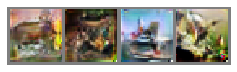

schedular lr [0.00018555600000000002]
Epoch 46 of 636,  Discriminator loss -0.3178655832863537 and Generator loss 8.026016272604465


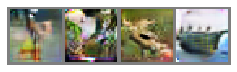

schedular lr [0.00018398600000000002]
Epoch 51 of 636,  Discriminator loss -0.316982436806533 and Generator loss 8.461923548951745


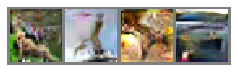

schedular lr [0.000182416]
Epoch 56 of 636,  Discriminator loss -0.3413183884873132 and Generator loss 9.045147344470024


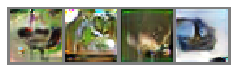

schedular lr [0.000180846]
Epoch 61 of 636,  Discriminator loss -0.3381813107782109 and Generator loss 6.8669252172112465


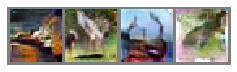

schedular lr [0.000179276]
Epoch 66 of 636,  Discriminator loss -0.31283013119249586 and Generator loss 8.486098781228065


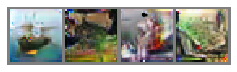

schedular lr [0.00017770600000000002]
Epoch 71 of 636,  Discriminator loss -0.32769371255947527 and Generator loss 9.26453484594822


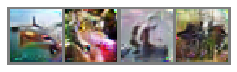

schedular lr [0.00017613600000000002]
Epoch 76 of 636,  Discriminator loss -0.3449559537041339 and Generator loss 9.047113806009293


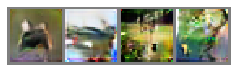

schedular lr [0.000174566]
Epoch 81 of 636,  Discriminator loss -0.3626241048050534 and Generator loss 8.684966057538986


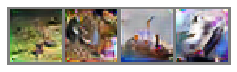

schedular lr [0.000172996]
Epoch 86 of 636,  Discriminator loss -0.3337559302094256 and Generator loss 8.521848537027836


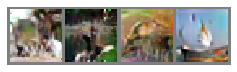

schedular lr [0.000171426]
Epoch 91 of 636,  Discriminator loss -0.36006117476874094 and Generator loss 8.533458553254604


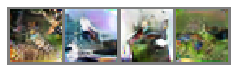

schedular lr [0.00016985600000000002]
Epoch 96 of 636,  Discriminator loss -0.37433555741219005 and Generator loss 8.706881314516068


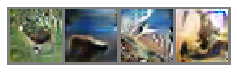

schedular lr [0.00016828600000000002]
Epoch 101 of 636,  Discriminator loss -0.3700970272966631 and Generator loss 8.816159099340439


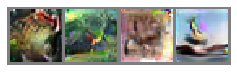

schedular lr [0.000166716]
Epoch 106 of 636,  Discriminator loss -0.3866804268946693 and Generator loss 7.360629379749298


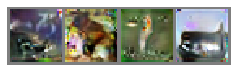

schedular lr [0.000165146]
Epoch 111 of 636,  Discriminator loss -0.38214749498826683 and Generator loss 9.742922320961952


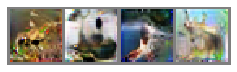

schedular lr [0.000163576]
Epoch 116 of 636,  Discriminator loss -0.4118968452190518 and Generator loss 9.083499521017075


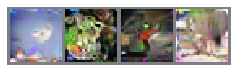

schedular lr [0.00016200600000000002]
Epoch 121 of 636,  Discriminator loss -0.40666743166222696 and Generator loss 8.753941394388676


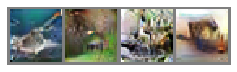

schedular lr [0.00016043600000000002]
Epoch 126 of 636,  Discriminator loss -0.4262815387385666 and Generator loss 6.935919062001631


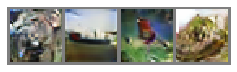

schedular lr [0.000158866]
Epoch 131 of 636,  Discriminator loss -0.4412878212418146 and Generator loss 7.981760665774345


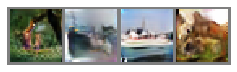

schedular lr [0.000157296]
Epoch 136 of 636,  Discriminator loss -0.3112014269183396 and Generator loss 9.034192830324173


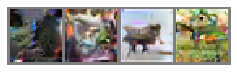

schedular lr [0.000155726]
Epoch 141 of 636,  Discriminator loss -0.45045147031830374 and Generator loss 10.190524578094482


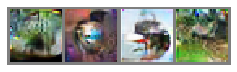

schedular lr [0.00015415600000000002]
Epoch 146 of 636,  Discriminator loss -0.5068384611824895 and Generator loss 9.493603482842445


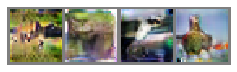

schedular lr [0.00015258600000000002]
Epoch 151 of 636,  Discriminator loss -0.5079560171883957 and Generator loss 8.86290629208088


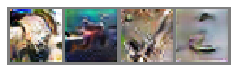

schedular lr [0.000151016]
Epoch 156 of 636,  Discriminator loss -0.5177018240948391 and Generator loss 8.514644786715508


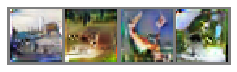

schedular lr [0.00014944600000000002]
Epoch 161 of 636,  Discriminator loss -0.14900568118140955 and Generator loss 12.91050036251545


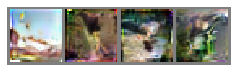

schedular lr [0.000147876]
Epoch 166 of 636,  Discriminator loss -0.46965287675618367 and Generator loss 10.084078893065453


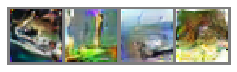

schedular lr [0.00014630600000000002]
Epoch 171 of 636,  Discriminator loss -0.49079281371680034 and Generator loss 9.197651356458664


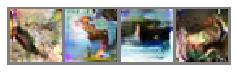

schedular lr [0.00014473600000000002]
Epoch 176 of 636,  Discriminator loss -0.529714935192257 and Generator loss 11.537895292043686


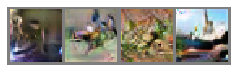

schedular lr [0.000143166]
Epoch 181 of 636,  Discriminator loss -0.5398061594623289 and Generator loss 12.687140554189682


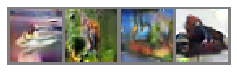

schedular lr [0.00014159600000000002]
Epoch 186 of 636,  Discriminator loss -0.5712770133925851 and Generator loss 11.304203748703003


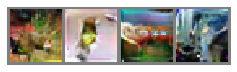

schedular lr [0.000140026]
Epoch 191 of 636,  Discriminator loss -0.5736941291600656 and Generator loss 11.917994111776352


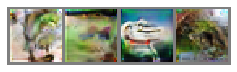

schedular lr [0.00013845600000000002]
Epoch 196 of 636,  Discriminator loss -0.6151261011933445 and Generator loss 12.570146389305592


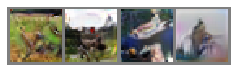

schedular lr [0.000136886]
Epoch 201 of 636,  Discriminator loss -0.62644152450049 and Generator loss 11.903151512145996


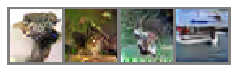

schedular lr [0.000135316]
Epoch 206 of 636,  Discriminator loss -0.7167197887067962 and Generator loss 12.252135530114174


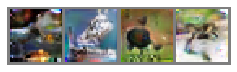

schedular lr [0.00013374600000000002]
Epoch 211 of 636,  Discriminator loss -0.6125762982495652 and Generator loss 12.618623435497284


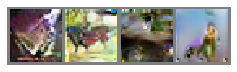

schedular lr [0.000132176]
Epoch 216 of 636,  Discriminator loss -0.6000801033702245 and Generator loss 10.924478143453598


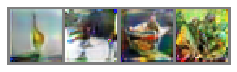

schedular lr [0.00013060600000000002]
Epoch 221 of 636,  Discriminator loss -0.5737075043759149 and Generator loss 12.002602905035019


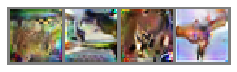

schedular lr [0.000129036]
Epoch 226 of 636,  Discriminator loss -0.20111767783950849 and Generator loss 16.11062127351761


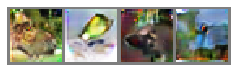

schedular lr [0.000127466]
Epoch 231 of 636,  Discriminator loss -0.7310516060134218 and Generator loss 15.71746315062046


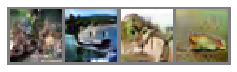

schedular lr [0.00012589600000000002]
Epoch 236 of 636,  Discriminator loss -0.7588326350139205 and Generator loss 11.357942257076502


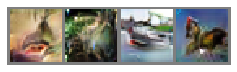

schedular lr [0.000124326]
Epoch 241 of 636,  Discriminator loss -0.3930485142738956 and Generator loss 18.145481377840042


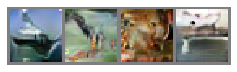

schedular lr [0.00012275600000000002]
Epoch 246 of 636,  Discriminator loss -0.5276238063148632 and Generator loss 13.55175405740738


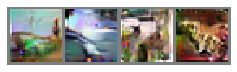

schedular lr [0.000121186]
Epoch 251 of 636,  Discriminator loss -0.5890783106635331 and Generator loss 13.481012612581253


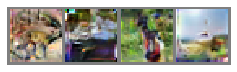

schedular lr [0.000119616]
Epoch 256 of 636,  Discriminator loss -0.6117344952550283 and Generator loss 14.753592878580093


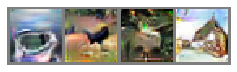

schedular lr [0.00011804600000000001]
Epoch 261 of 636,  Discriminator loss -0.6333795704279735 and Generator loss 15.399226993322372


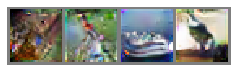

schedular lr [0.00011647599999999999]
Epoch 266 of 636,  Discriminator loss -0.5918649357690173 and Generator loss 15.338978841900826


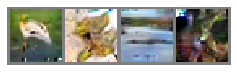

schedular lr [0.000114906]
Epoch 271 of 636,  Discriminator loss -0.6421042139268225 and Generator loss 16.28070429712534


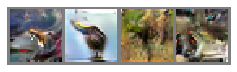

schedular lr [0.000113336]
Epoch 276 of 636,  Discriminator loss -0.6955178040939911 and Generator loss 16.661429964005947


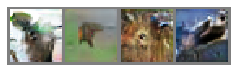

schedular lr [0.00011176599999999999]
Epoch 281 of 636,  Discriminator loss -0.695493537505531 and Generator loss 18.7808425873518


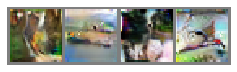

schedular lr [0.00011019600000000001]
Epoch 286 of 636,  Discriminator loss -0.7307954382649653 and Generator loss 18.343101128935814


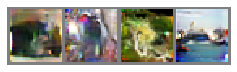

schedular lr [0.00010862599999999999]
Epoch 291 of 636,  Discriminator loss -0.9063638723959588 and Generator loss 15.977592840790749


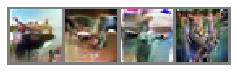

schedular lr [0.000107056]
Epoch 296 of 636,  Discriminator loss -0.7737552839669453 and Generator loss 13.681251809000969


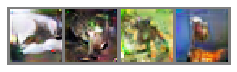

schedular lr [0.000105486]
Epoch 301 of 636,  Discriminator loss -0.4109396777904717 and Generator loss 19.08872513473034


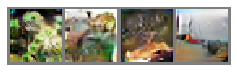

schedular lr [0.00010391599999999999]
Epoch 306 of 636,  Discriminator loss -0.25213977419267036 and Generator loss 15.05443175137043


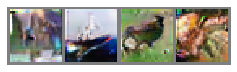

schedular lr [0.00010234600000000001]
Epoch 311 of 636,  Discriminator loss -0.6303789441942409 and Generator loss 13.634870436042547


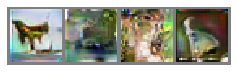

schedular lr [0.00010077599999999999]
Epoch 316 of 636,  Discriminator loss -0.6952384480150642 and Generator loss 23.18805241584778


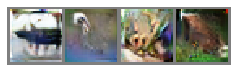

schedular lr [9.9206e-05]
Epoch 321 of 636,  Discriminator loss -0.5961737320016903 and Generator loss 18.276628851890564


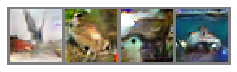

schedular lr [9.7636e-05]
Epoch 326 of 636,  Discriminator loss -1.120305499785645 and Generator loss 17.853860277682543


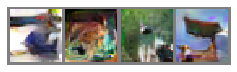

schedular lr [9.606599999999998e-05]
Epoch 331 of 636,  Discriminator loss -0.3601720857961922 and Generator loss 22.881981760263443


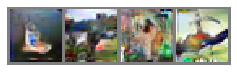

schedular lr [9.449600000000001e-05]
Epoch 336 of 636,  Discriminator loss -0.6661756802943481 and Generator loss 21.61056862771511


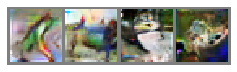

schedular lr [9.2926e-05]
Epoch 341 of 636,  Discriminator loss -0.9682654328169716 and Generator loss 15.926154490560293


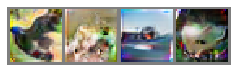

schedular lr [9.1356e-05]
Epoch 346 of 636,  Discriminator loss -0.6509619927282926 and Generator loss 15.428273599594831


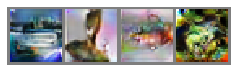

schedular lr [8.9786e-05]
Epoch 351 of 636,  Discriminator loss -0.8573566635560458 and Generator loss 20.310591598041356


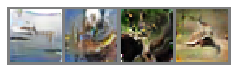

schedular lr [8.821599999999998e-05]
Epoch 356 of 636,  Discriminator loss -0.17585714123431284 and Generator loss 21.03244987130165


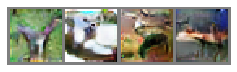

schedular lr [8.664600000000001e-05]
Epoch 361 of 636,  Discriminator loss -1.7254038868816035 and Generator loss 14.256182253360748


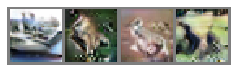

schedular lr [8.5076e-05]
Epoch 366 of 636,  Discriminator loss -0.46093690812967386 and Generator loss 21.129849284887314


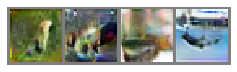

schedular lr [8.3506e-05]
Epoch 371 of 636,  Discriminator loss -0.35287740596445505 and Generator loss 22.959659814834595


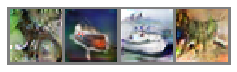

schedular lr [8.1936e-05]
Epoch 376 of 636,  Discriminator loss -0.5722762989770075 and Generator loss 19.382043164223433


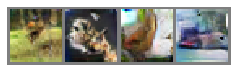

schedular lr [8.036599999999998e-05]
Epoch 381 of 636,  Discriminator loss -0.6515912492848506 and Generator loss 15.88096921890974


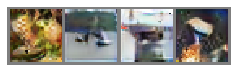

schedular lr [7.879600000000001e-05]
Epoch 386 of 636,  Discriminator loss -0.41581217515145896 and Generator loss 27.204622894525528


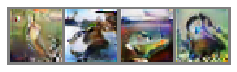

schedular lr [7.7226e-05]
Epoch 391 of 636,  Discriminator loss 0.3072739160459512 and Generator loss 27.05774277448654


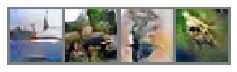

schedular lr [7.5656e-05]
Epoch 396 of 636,  Discriminator loss -0.10427488787633599 and Generator loss 28.346798062324524


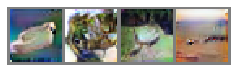

schedular lr [7.4086e-05]
Epoch 401 of 636,  Discriminator loss -0.6717612266920174 and Generator loss 20.02914845943451


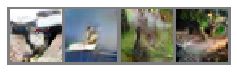

schedular lr [7.251599999999998e-05]
Epoch 406 of 636,  Discriminator loss -1.1883572250794454 and Generator loss 18.816372856497765


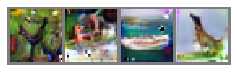

schedular lr [7.0946e-05]
Epoch 411 of 636,  Discriminator loss -0.24442397240715422 and Generator loss 24.543661892414093


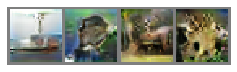

schedular lr [6.9376e-05]
Epoch 416 of 636,  Discriminator loss -2.5811382247858745 and Generator loss 20.28692863881588


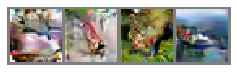

schedular lr [6.7806e-05]
Epoch 421 of 636,  Discriminator loss -0.6498624989940862 and Generator loss 21.179778322577477


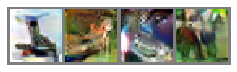

schedular lr [6.623599999999998e-05]
Epoch 426 of 636,  Discriminator loss -1.7389248593407831 and Generator loss 12.469974473118782


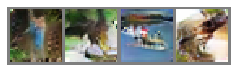

schedular lr [6.466599999999998e-05]
Epoch 431 of 636,  Discriminator loss 0.2673466010078503 and Generator loss 14.650754198431969


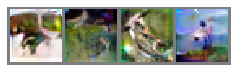

schedular lr [6.3096e-05]
Epoch 436 of 636,  Discriminator loss -0.22164980502455098 and Generator loss 21.959139347076416


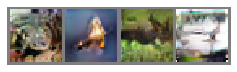

schedular lr [6.1526e-05]
Epoch 441 of 636,  Discriminator loss -0.46856663969292 and Generator loss 21.546500027179718


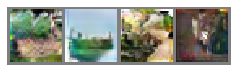

schedular lr [5.995599999999999e-05]
Epoch 446 of 636,  Discriminator loss -0.5383771728415778 and Generator loss 18.994434433057904


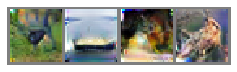

schedular lr [5.8385999999999986e-05]
Epoch 451 of 636,  Discriminator loss -0.9103273918057323 and Generator loss 16.438474255613983


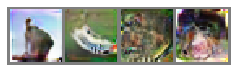

schedular lr [5.681599999999998e-05]
Epoch 456 of 636,  Discriminator loss -0.6150601197295128 and Generator loss 12.114631906151772


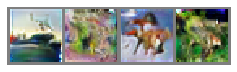

schedular lr [5.5246e-05]
Epoch 461 of 636,  Discriminator loss -0.5969194959683023 and Generator loss 11.969196148216724


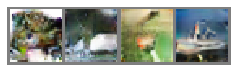

schedular lr [5.367599999999999e-05]
Epoch 466 of 636,  Discriminator loss -0.5629294777561904 and Generator loss 14.49862739816308


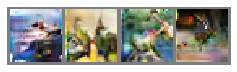

schedular lr [5.2105999999999985e-05]
Epoch 471 of 636,  Discriminator loss -0.5406436493537229 and Generator loss 16.117263615131378


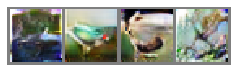

schedular lr [5.0535999999999985e-05]
Epoch 476 of 636,  Discriminator loss -1.2432249927549226 and Generator loss 14.992795063182712


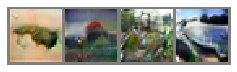

schedular lr [4.8966e-05]
Epoch 481 of 636,  Discriminator loss -0.524054859070831 and Generator loss 17.5992920845747


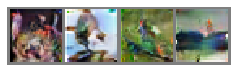

schedular lr [4.7396e-05]
Epoch 486 of 636,  Discriminator loss -0.7997240781024763 and Generator loss 22.80557855963707


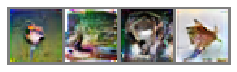

schedular lr [4.582599999999999e-05]
Epoch 491 of 636,  Discriminator loss -0.8831254102906604 and Generator loss 16.933874674141407


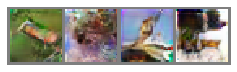

schedular lr [4.4255999999999984e-05]
Epoch 496 of 636,  Discriminator loss -0.5141775114046541 and Generator loss 17.537885636091232


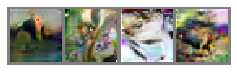

schedular lr [4.2685999999999984e-05]
Epoch 501 of 636,  Discriminator loss -0.2429408641994759 and Generator loss 20.086786657571793


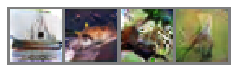

KeyboardInterrupt: ignored

In [53]:
for epoch in range(epochz,num_epochs):

    batch_d_loss, batch_g_loss = [], []
    
    for x, _ in trainloader:

        batch_size = x.size(0)

        #for p in discriminator.parameters():  # reset requires_grad
        #    p.requires_grad = True  # they are set to False below in netG update

        #for _ in range(n_critic):
        # 1. Train Discriminator
        # Step 1
        # Generate fake data
        # Note: detach() is used to avoid compounding generator gradients
        z = torch.FloatTensor(batch_size, 128).to(device)
        x_fake = generator.forward(z.normal_(0,1)).detach()
        
        
        # Step 2. Send real data through discriminator
        #         and backpropagate its errors.
        x_true = x.to(device)     

        x_true.requires_grad_()
        x_fake.requires_grad_()

        d_error = train_discriminator(discriminator_optim, x_true, x_fake) 

        # Append to list
        batch_d_loss.append((d_error).item())

        if global_step%n_critic ==0:
            # 2. Train Generator

            #for p in discriminator.parameters():  # reset requires_grad
            #    p.requires_grad = False  #  to avoid computation

            # Generate fake data
            x_fake = generator.forward(z.normal_(0,1))
            # Train G
            g_error = train_generator(generator_optim, x_fake)
            # Append to list
            batch_g_loss.append(g_error.item())
            
        # Update number of batch steps
        global_step += 1
        del x_fake
        del x_true
        
        # Take scheduler step
        scheduler_gen.step()
        scheduler_disc.step()
        
    # Mean list
    discriminator_loss.append(np.mean(batch_d_loss))
    generator_loss.append(np.mean(batch_g_loss))



    # Save models
    torch.save({
            'epoch': epoch,
            'disc': discriminator.state_dict(),
            'disc_optim': discriminator_optim.state_dict(),
            'gen': generator.state_dict(),
            'gen_optim': generator_optim.state_dict(),
            'disc_loss': discriminator_loss,
            'gen_loss': generator_loss,
            'global_step': global_step,
            'incept_mean_list': incept_mean_list,
            'incept_std_list': incept_std_list
            }, path)

    if epoch % 5==0:

        # Get inception score
        incept_mean, incept_std = get_inception_Score(generator)
        incept_mean_list.append(incept_mean)
        incept_std_list.append(incept_std)

        print('schedular lr {}'.format(scheduler_gen.get_lr()))
        print('Epoch {} of {},  Discriminator loss {} and Generator loss {}'.format(epoch+1,num_epochs,discriminator_loss[-1],generator_loss[-1]))


        # Generate data
        with torch.no_grad():
            z = torch.FloatTensor(4, 128).to(device)
            x_fake = generator.forward(z.normal_(0,1)).detach()
        
        show(x_fake.cpu())


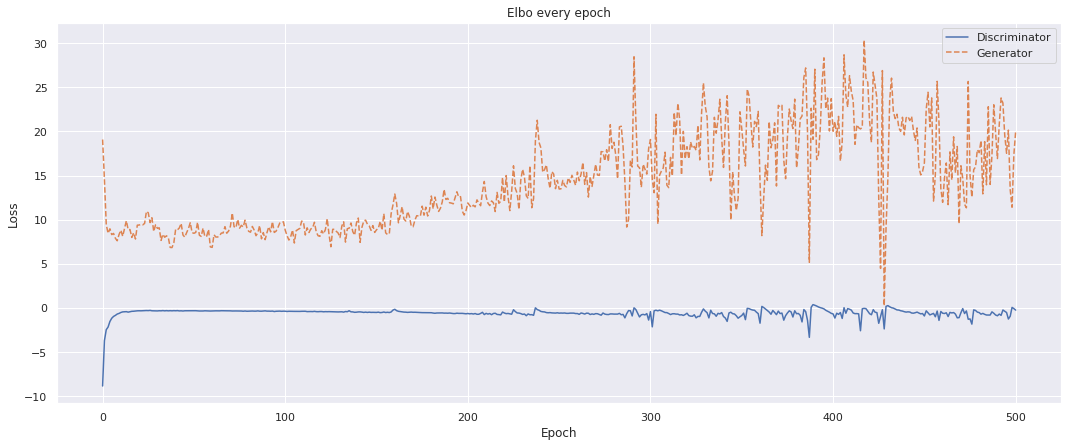

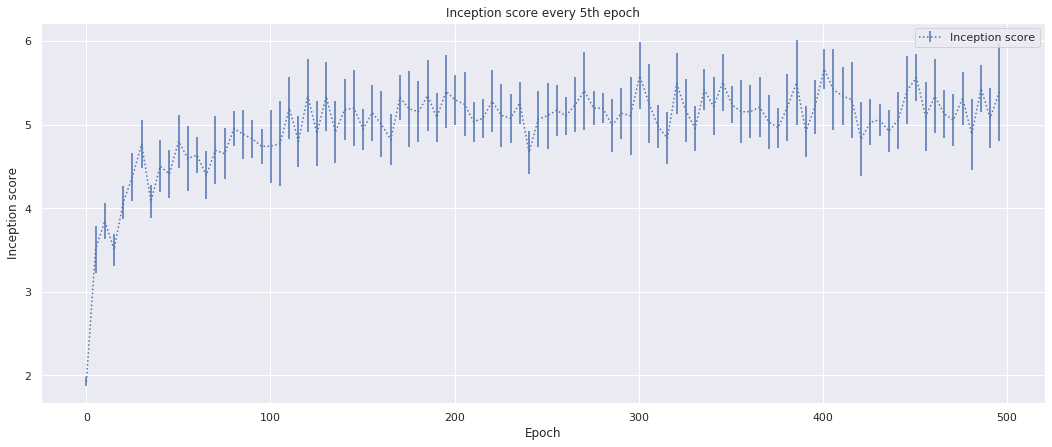

In [65]:
import matplotlib.pyplot as plt
import numpy as np 
# -- Plotting --
f, axarr = plt.subplots(1, 1, figsize=(18, 7))

# Loss
ax = axarr
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.plot(np.arange(len(discriminator_loss)), discriminator_loss)
ax.plot(np.arange(len(generator_loss)), generator_loss, linestyle="--")
ax.set_title('Elbo every epoch')
ax.legend(['Discriminator', 'Generator'])

# -- Plotting --
f, axarr = plt.subplots(1, 1, figsize=(18, 7))

# Loss
ax = axarr
ax.set_xlabel('Epoch')
ax.set_ylabel('Inception score')
ax.set_title('Inception score every 5th epoch')

ax.errorbar(np.arange(0,len(generator_loss),(len(generator_loss)/len( incept_mean_list))), incept_mean_list,yerr=incept_std_list,linestyle='dotted')
ax.legend(['Inception score'])



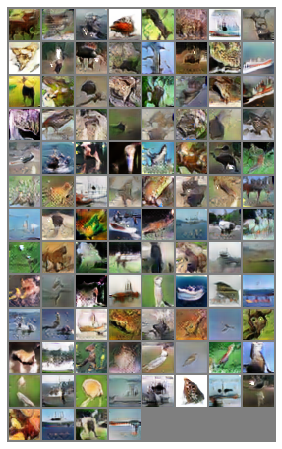

In [68]:
# Generate data
with torch.no_grad():
    z = torch.FloatTensor(100, 128).to(device)
    x_fake = generator.forward(z.normal_(0,1)).detach()

show(x_fake.cpu())

In [0]:
incept_mean, incept_std = get_inception_Score(generator)

In [77]:
print('Final mean Inception score: {} with a std of: {}'.format(incept_mean, incept_std))

Final mean Inception score: 5.575281620025635 with a std of: 0.38694459199905396
